In [ ]:
!pip install tensorflow==2.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 46.0 MB/s eta 0:00:0000:01:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
base_dir = '/kaggle/input/masked-dataset'
categories = ['Benign', 'Early', 'Pre', 'Pro']

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
data = []
for category in categories:
    category_dir = os.path.join(base_dir, category)
    for filename in os.listdir(category_dir):
        data.append((os.path.join(category_dir, filename), category))

df = pd.DataFrame(data, columns=['filename', 'category'])

df['label'] = df['category'].astype('category').cat.codes

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
train_df, validation_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filename",
    y_col="category",
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    color_mode= 'rgb',
    shuffle= True,
    seed=42
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col="filename",
    y_col="category",
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    color_mode= 'rgb',
    shuffle=False
)

test_generator = validation_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filename",
    y_col="category",
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    color_mode= 'rgb',
    shuffle=False
)

Found 2083 validated image filenames belonging to 4 classes.
Found 521 validated image filenames belonging to 4 classes.
Found 652 validated image filenames belonging to 4 classes.


In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_50 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             

 Total params: 26,448,196 (100.89 MB)

 Trainable params: 26,448,196 (100.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,
    verbose=1,
    batch_size=16,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 54s 349ms/step - accuracy: 0.4377 - loss: 1.2985 - val_accuracy: 0.8253 - val_loss: 0.5213
Epoch 2/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 306ms/step - accuracy: 0.7985 - loss: 0.5613 - val_accuracy: 0.8714 - val_loss: 0.3414
Epoch 3/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 311ms/step - accuracy: 0.8239 - loss: 0.4399 - val_accuracy: 0.9386 - val_loss: 0.1805
Epoch 4/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 300ms/step - accuracy: 0.8801 - loss: 0.3138 - val_accuracy: 0.9367 - val_loss: 0.1810
Epoch 5/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 312ms/step - accuracy: 0.8964 - loss: 0.2638 - val_accuracy: 0.9578 - val_loss: 0.1130
Epoch 6/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 302ms/step - accuracy: 0.9056 - loss: 0.2452 - val_accuracy: 0.9405 - val_loss: 0.1636
Epoch 7/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 310ms/step - accuracy: 0.9339 - loss: 0.1968 - val_accuracy: 0.9616 - val_loss: 0.0943
Epoch 8/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 312ms/step - accuracy: 0.9528 - loss: 0

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 402ms/step - accuracy: 0.9803 - loss: 0.0526
Test Loss: 0.05865277349948883
Test Accuracy: 0.9800613522529602


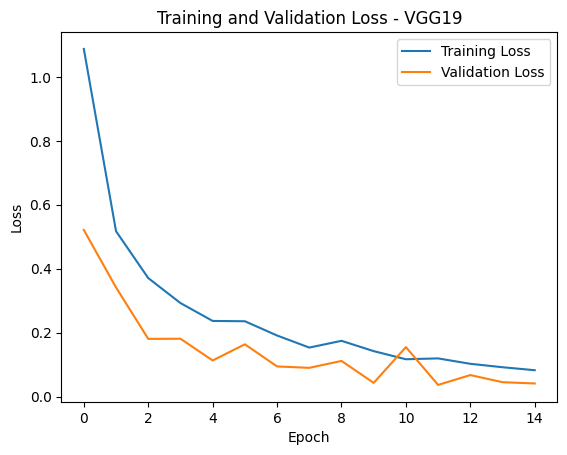

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - VGG19')
plt.legend()
plt.show()

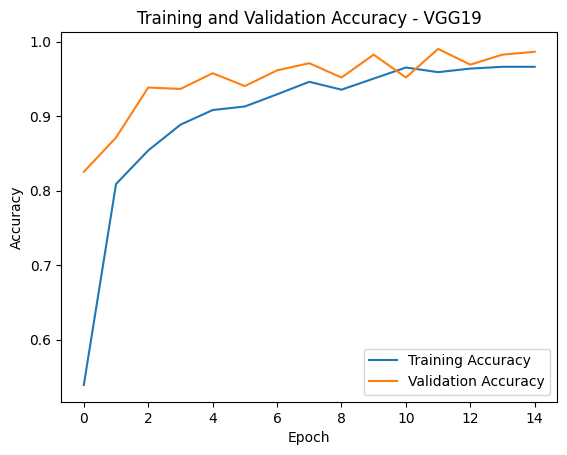

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy - VGG19')
plt.legend()
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step


<Figure size 1000x600 with 0 Axes>

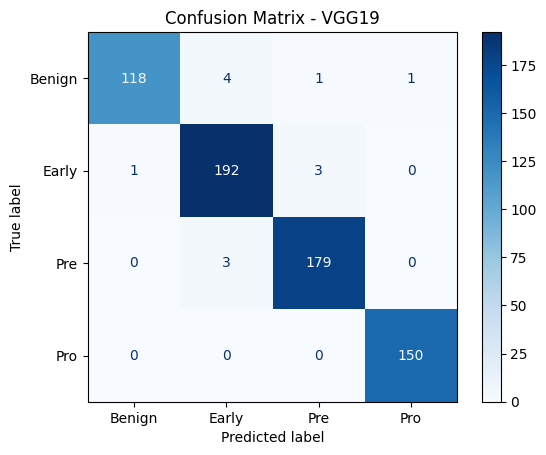

In [ ]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - VGG19')
plt.show()

In [ ]:
report = classification_report(y_true, y_pred_classes, target_names=categories)
accuracy = accuracy_score(y_true, y_pred_classes)

print("VGG19 Classification Report:")
print(report)
print("VGG19 Accuracy:", accuracy)

VGG19 Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.95      0.97       124
       Early       0.96      0.98      0.97       196
         Pre       0.98      0.98      0.98       182
         Pro       0.99      1.00      1.00       150

    accuracy                           0.98       652
   macro avg       0.98      0.98      0.98       652
weighted avg       0.98      0.98      0.98       652

VGG19 Accuracy: 0.9800613496932515


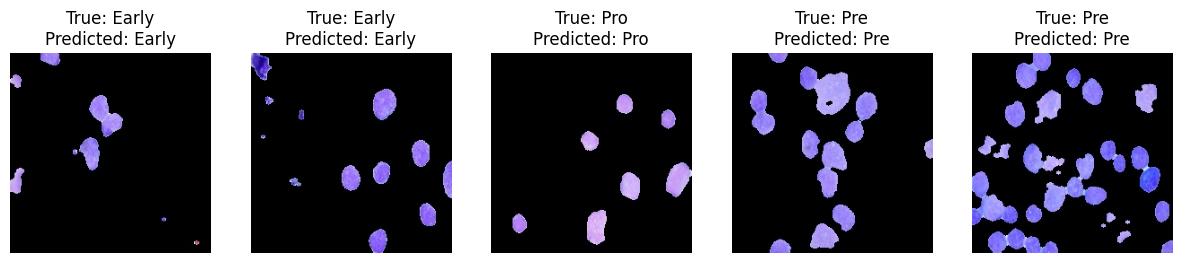

In [ ]:
sample_size = 5
random_indices = random.sample(range(len(test_df)), sample_size)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    filename = test_df.iloc[idx]['filename']
    true_label = test_df.iloc[idx]['category']
    img = plt.imread(filename)
    plt.subplot(1, sample_size, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'True: {true_label}\nPredicted: {categories[y_pred_classes[idx]]}')

plt.show()